In [11]:
# import libs
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import os
import pathlib as Path
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# sort the data into the correct format
def data_loader(folder_path):
    
    column_names = ['DateTimeUTC', 'LocationId', 'Latitude', 'Longitude', 'dni', 'dhi', 'ghi']
    
    files = os.listdir(folder_path)
    
    dfs = []
    
    for filename in files:
        if filename.endswith(".csv") and not filename.startswith("._"):
            file_path = os.path.join(folder_path, filename)
            print(file_path)
            print(filename)
            df = pd.read_csv(file_path, header=None, names=column_names, parse_dates=['DateTimeUTC'])
            
            # Remove the .csv
            datetime_str = filename[:-4] 
            # Convert the filename to a datetime object
            datetime_obj = datetime.strptime(datetime_str, "%Y%m%d%H")

            df['step'] = (df['DateTimeUTC'] - datetime_obj).dt.total_seconds() / 3600  # convert timedelta to hours
            
            df['init_time'] = datetime_obj
            
            dfs.append(df)
        
    
    return dfs
    

In [ ]:
def load_data_from_all_years(parent_folder_path):
    # Initialize an empty list to store the dataframes
    all_dataframes = []

    # Loop over each year's folder and call the folder_data_load_sorted function
    for year in range(2018, 2019):
        folder_path = os.path.join(parent_folder_path, str(year))
        dataframes = data_loader(folder_path)
        all_dataframes.extend(dataframes)

    return all_dataframes

In [ ]:
def pdtocdf(dfs):
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    ds = xr.Dataset.from_dataframe(merged_df)
   
    ds = ds.set_index(index=['init_time', 'step','Latitude','Longitude']).unstack('index')
    
    
#     ds = ds.assign_coords(latitude=ds["Latitude"])
#     ds = ds.assign_coords(longitude=ds["Longitude"])
    
#     ds = ds.drop("Latitude")
#     ds = ds.drop("Longitude")
    
    
    ds = ds.drop_vars(["LocationId", "DateTimeUTC"])
    
    var_names = ds.data_vars
    d2 = xr.concat([ds[v] for v in var_names], dim="variable")

    # Set the coordinates to keep the names of the variables.
    d2 = d2.assign_coords(variable=("variable", var_names))

    # Turn the xr.DataArray into a xr.Dataset.
    ds = xr.Dataset(dict(value=d2))

    #When datesets are merged the steps can be out of order, so we sort them
    ds = ds.sortby('step')
    ds = ds.sortby('init_time')

    
#     ds = ds.rename({"UtcDatetime": "ts", "SiteId": "pv_id"})
    
#     ds = ds.drop_vars(["Unnamed: 0", "PostCode"])
#     ds = ds.rename({"UtcDatetime": "ts", "SiteId": "pv_id"})
    ds = ds.rename({"Latitude": "latitude", "Longitude": "longitude"})

    
    

    # Convert 'step' and 'ts' variables to dimensions
    # Drop the 'dim_0' dimension
#     ds = ds.set_coords("ts").swap_dims({"dim_0": "ts"})

#     ds = ds.drop("dim_0")

#     # Set 'step' and 'ts' as dimensions
#     ds = ds.set_coords('step')
    
#     ds = ds.set_coords('Latitude')
#     ds = ds.set_coords('Longitude')
    
    return ds

In [ ]:
def main():
    PATH = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/solar_data"
    dfs = load_data_from_all_years(PATH)
    ds = pdtocdf(dfs)
#     ds.to_zarr('excarta_SI.nc')
    return ds

In [ ]:
ds = main()

In [ ]:
ds

In [ ]:
dfs = data_loader("/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/solar_data/2021")

In [ ]:
dfs

In [ ]:
# root_dir = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/solar_radiation_UK_Malta_17_23_1calcperday/solar_data")
PATH = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/solar_data"

YEARS = [2018,2019,2020,2021,2022]
column_names = ['DateTimeUTC', 'LocationId', 'Latitude', 'Longitude', 'dni', 'dhi', 'ghi']


In [ ]:
NWP_PATH = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/clients/island/nwp_v8.zarr"


In [ ]:
# Load the data as an xarray dataset
dataset = xr.open_dataset(NWP_PATH)
dataset

In [ ]:
#Low memory script
import os
from datetime import datetime
import pandas as pd
import xarray as xr
import argparse
import pathlib


# def _parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("output", type=pathlib.Path, help="Output zarr file")
#     return parser.parse_args()


def data_loader(folder_path):
    """
    Loads and transforms data from CSV files in the given folder_path and directly convert each DataFrame into an xarray Dataset.
    """
    column_names = ['DateTimeUTC', 'LocationId', 'Latitude', 'Longitude', 'dni', 'dhi', 'ghi']
    files = os.listdir(folder_path)
    datasets = []

    for filename in files:
        if filename.endswith(".csv") and not filename.startswith("._"):
            file_path = os.path.join(folder_path, filename)

            df = pd.read_csv(file_path, header=None, names=column_names, parse_dates=['DateTimeUTC'])
            datetime_str = filename[:-4]
            datetime_obj = datetime.strptime(datetime_str, "%Y%m%d%H")
            df['step'] = (df['DateTimeUTC'] - datetime_obj).dt.total_seconds() / 3600  # convert timedelta to hours
            df['init_time'] = datetime_obj

            # Convert the dataframe to an xarray Dataset and append to the list
            ds = xr.Dataset.from_dataframe(df)
            ds = ds.drop_vars(["LocationId", "DateTimeUTC"])
            datasets.append(ds)

    return datasets


def load_data_from_all_years(parent_folder_path):
    all_datasets = []

    for year in range(2026, 2027):
        folder_path = os.path.join(parent_folder_path, str(year))
        datasets = data_loader(folder_path)
        all_datasets.extend(datasets)

    return all_datasets


def pdtocdf(datasets):
    """
    Processes the xarray Datasets and merges them.
    """
    print(datasets)
#     ds = xr.merge(datasets)

#     ds = ds.set_index(index=['init_time', 'step', 'Latitude', 'Longitude']).unstack('index')
        # Step 1: Set 'init_time', 'step', 'latitude', and 'longitude' as a multi-index
    datasets = [ds.set_index(index=['init_time', 'step', 'Latitude', 'Longitude']) for ds in datasets]

    # Step 2: Concatenate all Datasets along the new multi-index
    ds = xr.concat(datasets, dim='index')
    
    var_names = ds.data_vars
    d2 = xr.concat([ds[v] for v in var_names], dim="variable")
    d2 = d2.assign_coords(variable=("variable", var_names))
    ds = xr.Dataset(dict(value=d2))
    ds = ds.sortby('step')
    ds = ds.sortby('init_time')
    ds = ds.sortby('Latitude')
    ds = ds.sortby('Longitude')
    ds = ds.rename({"Latitude": "y", "Longitude": "x"})

    return ds


def main():
# #     args = _parse_args()

#     if args.output.exists():
#         raise RuntimeError(f'Output file "{args.output}" already exist')

    PATH = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/solar_data"
    datasets = load_data_from_all_years(PATH)
    ds = pdtocdf(datasets)
#     ds.to_zarr(args.output)
    
    return ds


In [ ]:
ds = main()

In [ ]:
ds

In [ ]:
import matplotlib.pyplot as plt

ds= unstacked_ds

# Select the data for a given init_time, x, and y
selected_data = ds['value'].sel(variable='dhi', init_time='2019-09-27T00', x=13.250000, y=35.250000)#,method='nearest')

# Create a plot
plt.figure(figsize=(10, 6))
selected_data.plot.line('o-')
plt.title('dhi vs step')
plt.xlabel('step')
plt.ylabel('dhi')
plt.grid(True)
plt.show()

In [ ]:
print(selected_data)

In [ ]:
unstacked_ds = ds.unstack('index')

In [ ]:
unstacked_ds

In [ ]:
import matplotlib.pyplot as plt

ds= combined_ds

# Select the data for a given init_time, x, and y
selected_data = ds['value'].sel(variable='dhi', init_time='2019-09-27T00', x=13.250000, y=35.250000)#,method='nearest')

# Create a plot
plt.figure(figsize=(10, 6))
selected_data.plot.line('o-')
plt.title('dhi vs step')
plt.xlabel('step')
plt.ylabel('dhi')
plt.grid(True)
plt.show()

In [ ]:
# Drop all records that have a NaN value in the 'value' variable
combined_ds = unstacked_ds.dropna(dim='variable', subset=['value'])


In [ ]:
combined_ds

In [ ]:
unstacked_ds.to_zarr('/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/a1_2018_only.zarr')


In [ ]:
#read
path_2017 = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/b1_2017_only_t2.zarr"
dataset_2017 = xr.open_zarr(path_2017)

In [ ]:
dataset_2017

In [ ]:
# I could load this data into my nwp dashboard to explore the data
import matplotlib.pyplot as plt
import xarray as xr

data = dataset_2017

# Assuming your dataset is named 'data'
# Selecting a specific variable, init_time, and step
selected_data = data.sel(variable='ghi', init_time='2017-12-31T00', step=1)

# Accessing the values
values = selected_data['value']

values
# Plotting the values
# plt.imshow(values, origin='lower')
# plt.colorbar(label='Value')
# plt.title('Plot of GHI')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [ ]:
# Assuming your dataset is named 'data'
# Selecting a specific latitude and longitude
latitude = 49
longitude = -8


selected_data = data.sel(x=longitude, y=latitude,method='nearest')

# Selecting the specific variable
variable = 'dni'
selected_variable_data = selected_data.sel(variable=variable, init_time='2017-12-31T06')

# Accessing the values and step dimensions
values = selected_variable_data['value'].values
steps = selected_variable_data['step']

print("---")
print(values)
print("---")
print(steps)
# Plotting the line chart
plt.plot(values, steps)
plt.title(f'Line Chart of {variable.upper()} at Latitude: {latitude}, Longitude: {longitude}')
plt.xlabel('Step')
plt.ylabel(variable.upper())
plt.show()

In [ ]:
# Tsting monthly data

ds = xr.load_dataset("/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/r2201802.zarr")

In [ ]:
ds

In [ ]:
# Select the data for a given init_time, x, and y
selected_data = ds['value'].sel(variable='dhi', init_time='2018-02-01T00', x=13.250000, y=35.250000)#,method='nearest')

# Create a plot
plt.figure(figsize=(10, 6))
selected_data.plot.line('o-')
plt.title('dhi vs step')
plt.xlabel('step')
plt.ylabel('dhi')
plt.grid(True)
plt.show()

In [ ]:
ds

In [ ]:
import xarray as xr
import os

def merge_zarr_files(zarr_path, merged_zarr_path):
    # Collect paths of Zarr files in the specified directory
    zarr_files = [os.path.join(zarr_path, file) for file in os.listdir(zarr_path) if file.endswith('.zarr')]

    print("1")
    # Open the first Zarr file to create the initial dataset
    merged_ds = xr.open_zarr(zarr_files[0])
    
    print("2")

    # Iterate over the remaining Zarr files and merge them into the initial dataset
    for file in zarr_files[1:]:
        ds = xr.open_zarr(file)
        merged_ds = merged_ds.combine_first(ds)
        
    print("3")

    # Rechunk the merged dataset
    merged_ds = merged_ds.chunk(chunks={"init_time": 10, "x": 100, "y": 100})
    
    print("4")
    
    # Define the specific range of x and y coordinates
    x_range = (-10, 2)  # Example x coordinate range
    y_range = (49, 59)  # Example y coordinate range

    filtered_dataset = merged_ds.sel(x=slice(*x_range), y=slice(*y_range))
    
    print(filtered_dataset)

    # Save the merged dataset as a new Zarr file
    filtered_dataset.to_zarr(merged_zarr_path)
    
    print("5")
    
    


# Specify the path where the independent Zarr files are located
zarr_path = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/r3_test_merge"

# Specify the path for the merged Zarr file
merged_zarr_path = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/merged_excarta/merged_3_r3_test_merge_ukfilt_t2.zarr"

# Merge the Zarr files
merge_zarr_files(zarr_path, merged_zarr_path)



In [104]:

# path_zarr_test = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/r4/Malta/full_v2_201801.zarr"

path_zarr_test = "/mnt/storage_b/data/ocf/solar_pv_nowcasting/experimental/Excarta/sr_UK_Malta_full/zarr_format/r3/full_v1_202205.zarr"
ds = xr.open_zarr(path_zarr_test)

ds


<xarray.Dataset>
Dimensions:    (init_time: 124, step: 168, variable: 3, y: 122, x: 122)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2022-05-01 ... 2022-05-31T18:00:00
  * step       (step) float64 1.0 2.0 3.0 4.0 5.0 ... 165.0 166.0 167.0 168.0
  * variable   (variable) <U3 'dni' 'dhi' 'ghi'
  * x          (x) float64 -9.879 -9.758 -9.636 -9.515 ... 14.83 14.92 15.0
  * y          (y) float64 35.0 35.08 35.17 35.25 35.33 ... 58.7 58.8 58.9 59.0
Data variables:
    value      (variable, init_time, step, y, x) float64 dask.array<chunksize=(1, 16, 42, 31, 31), meta=np.ndarray>

In [105]:
print((ds.nbytes)/1000000)

7441.528036


In [106]:
print('dhi' in ds['value'].coords['variable'].values)
print('2018-01-04T06:00:00.000000000' in ds['value'].coords['init_time'].values)

print(np.all(np.diff(ds.coords['x']) > 0))  # For ascending. Output should be True.
print(np.all(np.diff(ds.coords['x']) < 0))  # For descending. Output should be True.

print(np.all(np.diff(ds.coords['y']) > 0))  # For ascending. Output should be True.
print(np.all(np.diff(ds.coords['y']) < 0))  # For descending. Output should be True.





True
False
True
False
True
False


/tmp/ipykernel_2050364/1594016849.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print('2018-01-04T06:00:00.000000000' in ds['value'].coords['init_time'].values)


In [107]:
print(ds['value'].coords['init_time'].values)


['2022-05-01T00:00:00.000000000' '2022-05-01T06:00:00.000000000'
 '2022-05-01T12:00:00.000000000' '2022-05-01T18:00:00.000000000'
 '2022-05-02T00:00:00.000000000' '2022-05-02T06:00:00.000000000'
 '2022-05-02T12:00:00.000000000' '2022-05-02T18:00:00.000000000'
 '2022-05-03T00:00:00.000000000' '2022-05-03T06:00:00.000000000'
 '2022-05-03T12:00:00.000000000' '2022-05-03T18:00:00.000000000'
 '2022-05-04T00:00:00.000000000' '2022-05-04T06:00:00.000000000'
 '2022-05-04T12:00:00.000000000' '2022-05-04T18:00:00.000000000'
 '2022-05-05T00:00:00.000000000' '2022-05-05T06:00:00.000000000'
 '2022-05-05T12:00:00.000000000' '2022-05-05T18:00:00.000000000'
 '2022-05-06T00:00:00.000000000' '2022-05-06T06:00:00.000000000'
 '2022-05-06T12:00:00.000000000' '2022-05-06T18:00:00.000000000'
 '2022-05-07T00:00:00.000000000' '2022-05-07T06:00:00.000000000'
 '2022-05-07T12:00:00.000000000' '2022-05-07T18:00:00.000000000'
 '2022-05-08T00:00:00.000000000' '2022-05-08T06:00:00.000000000'
 '2022-05-08T12:00:00.000

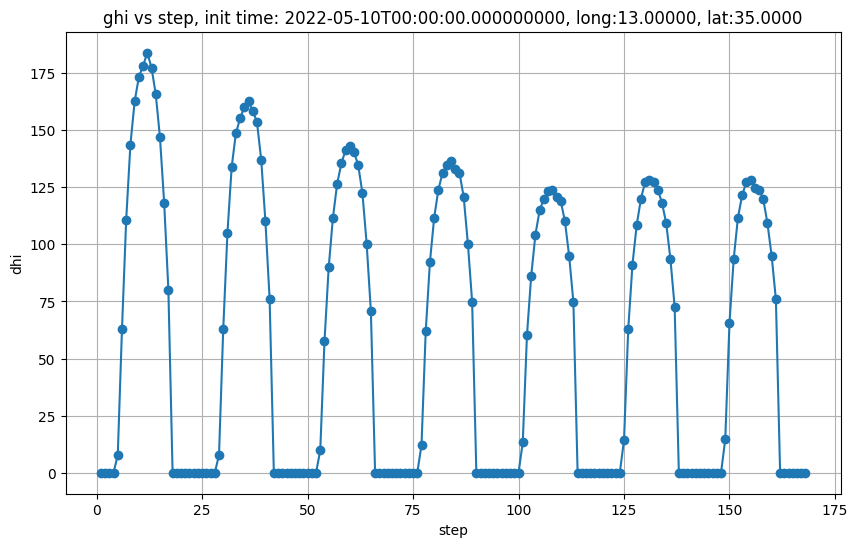

In [121]:
# Select the data for a given init_time, x, and y
selected_data = ds['value'].sel(variable='dhi', init_time='2022-05-10T00:00:00.000000000')

selected_data_2 = selected_data.sel(x=13.000000, y=35.000000 , method='nearest')

selected_data_2.values

# x=14.666667, y=35.166667
# x=13.250000, y=35.250000

# Create a plot
plt.figure(figsize=(10, 6))
selected_data_2.plot.line('o-')
plt.title('ghi vs step, init time: 2022-05-10T00:00:00.000000000, long:13.00000, lat:35.0000')
plt.xlabel('step')
plt.ylabel('dhi')
plt.grid(True)
plt.show()

In [109]:
# function to check quality of the data

import numpy as np
import pandas as pd
from itertools import product

# Function to count NaNs for each combination of x and y
def count_nans(ds):
  # Get unique values of x and y
  x_values = np.unique(ds['x'])
  y_values = np.unique(ds['y'])

  # Create an empty DataFrame
  df = pd.DataFrame(columns=['x', 'y', 'NaN Count'])

  # Iterating over each unique pair of x and y
  for x, y in product(x_values, y_values):
    # Select the data for that pair of x and y
    selected_data = ds['value'].sel(variable='dni', init_time='2018-01-06T00:00:00.000000000', x=x, y=y)
    
    # Counting the NaN values
    nan_count = np.isnan(selected_data.values).sum()

    # Append these values to a dataframe
    df = df.append({'x': x, 'y': y, 'NaN Count': nan_count}, ignore_index=True)
  
  return df

# Call the function
nan_count_df = count_nans(ds)

# Print the DataFrame
print(nan_count_df)


KeyError: "not all values found in index 'init_time'. Try setting the `method` keyword argument (example: method='nearest')."

In [110]:
nan_count_df.tail(60)

,x,y,NaN Count
565,14.833333,36.250000,168.0
566,14.833333,36.333333,168.0
567,14.833333,36.416667,168.0
568,14.833333,36.500000,168.0
569,14.833333,36.583333,168.0
570,14.833333,36.666667,168.0
571,14.833333,36.750000,168.0
572,14.833333,36.833333,0.0
573,14.833333,36.916667,168.0
574,14.833333,37.000000,168.0


In [111]:
# Select the data for a given init_time, x, and y
selected_data = ds['value'].sel(variable='dni', init_time='2018-01-06T00:00:00.000000000')

selected_data_2 = selected_data.sel(x=13.000000, y=35.000000 , method='nearest')

selected_data_2.values

KeyError: "not all values found in index 'init_time'. Try setting the `method` keyword argument (example: method='nearest')."

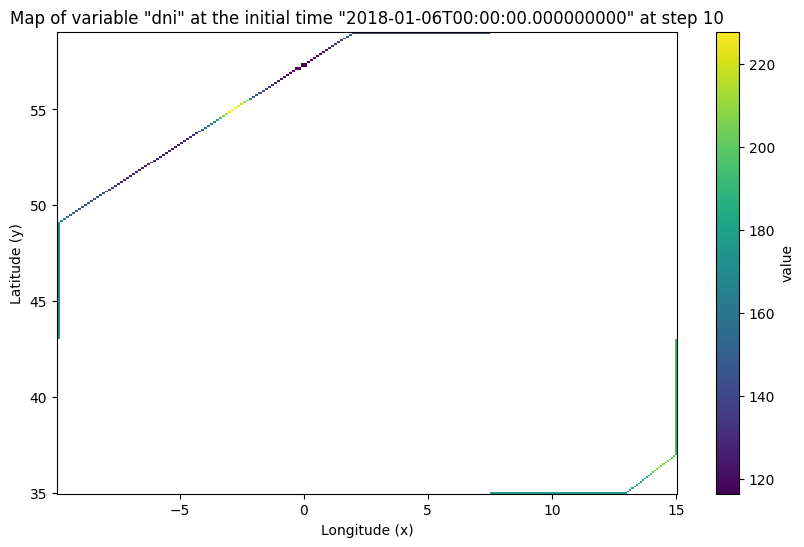

In [122]:
# 'selected_data' must be 2D for this to work, so let's take a slice along 'step'
selected_data_slice = selected_data.isel(step=10)

fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
selected_data_slice.plot(ax=ax, x='x', y='y')

# Set titles and labels
ax.set_title('Map of variable "dni" at the initial time "2018-01-06T00:00:00.000000000" at step 10')
ax.set_xlabel('Longitude (x)')
ax.set_ylabel('Latitude (y)')

plt.show()

In [89]:
# Check if there are any non-NaN values in the 'value' data variable
non_nan_exists = ds['value'].notnull().any().compute()

print(non_nan_exists)

<xarray.DataArray 'value' ()>
array(True)


In [90]:
selected_data.values

array([[[ 0., nan, nan, ..., nan, nan, nan],
        [nan,  0., nan, ..., nan, nan, nan],
        [nan, nan,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0., nan, nan],
        [nan, nan, nan, ..., nan,  0., nan],
        [nan, nan, nan, ..., nan, nan,  0.]],

       [[ 0., nan, nan, ..., nan, nan, nan],
        [nan,  0., nan, ..., nan, nan, nan],
        [nan, nan,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0., nan, nan],
        [nan, nan, nan, ..., nan,  0., nan],
        [nan, nan, nan, ..., nan, nan,  0.]],

       [[ 0., nan, nan, ..., nan, nan, nan],
        [nan,  0., nan, ..., nan, nan, nan],
        [nan, nan,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0., nan, nan],
        [nan, nan, nan, ..., nan,  0., nan],
        [nan, nan, nan, ..., nan, nan,  0.]],

       ...,

       [[ 0., nan, nan, ..., nan, nan, nan],
        [nan,  0., nan, ..., nan, nan, nan],
        [nan, nan,  0., ..., nan, nan, nan